# Stimulated emission protocol with OCT pulses followed by repeated π (n+1 and n+1) 

In [1]:
from pylab import*
import matplotlib.pyplot as plt
import seaborn as sns
from h5py import File
import pandas as pd
from slab.dsfit import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
# from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename

C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(7):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y
def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, np.inf))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# HMM Model

In [63]:
class hmm_analysis_stimem():

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = self.qubit_params['t1']
        self.qubit_t2 = self.qubit_params['t2']
        self.qubit_nth = self.qubit_params['nth']
        
        self.cavity_t1 = self.cavity_params['t1']
        self.cavity_nth = self.cavity_params['nth']
        
        self.readout_len = self.readout_params['length']        
        self.trigger_period = self.readout_params['trigger']
        self.pi_length = self.readout_params['pi_pulse']
        self.g_inf = self.readout_params['g_inf']        
        self.e_inf = self.readout_params['e_inf']      
        
    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx_mm\drive_calibration'

        fn_file = cal_path + '\\00000_2021_12_16_cavity_square_mode_2.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename=None, at_end=True, t2_err=0.0, fstate_in=0, hist_file=None):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = self.g_inf, self.e_inf
        
        self.a = self.openfile(data_filename)

        I = pd.DataFrame(self.a['I'])[:]
        Q = pd.DataFrame(self.a['bit'])[:]
        
        cav_amp = np.array(self.a['amp']) 
        cav_len = np.array(self.a['time']) 
        
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))
        alpha = np.array(self.a['alpha'])

        self.a.close()
        
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        p_m_counts = []
        p_n_counts = []
        
        """T and E matrices for the state prep part, π pulses at m (~n)"""
        if fstate_in ==0:
            cavity_t1 = self.cavity_t1/(fstate_in+1)
            #W is the m_bar state (undesired)
            Pmw = self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) #Only spontaneous excitation
            Pwm = (1-np.exp(-self.trigger_period/cavity_t1)) #Exponential decay

        else:
            cavity_t1 = self.cavity_t1/(fstate_in)
            Pmw = (1-np.exp(-self.trigger_period/cavity_t1)) +\
                        self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) + \
                        self.cavity_nth * (1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in+1))))
            
            Pwm = self.cavity_nth * (1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in))))
        
        Pmm = 1-Pmw
        Pww = 1-Pwm    
        """First term corresponds to to a spontaneous heating to the higher state (n+1) and
            the second terms corresponds to decay to a lower Fock state (n-1). 
            However, it is very unlikely that the cavity will start in (n+1) state
        """
        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                                    (1-np.exp(-self.pi_length/self.qubit_t2))
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                        (1-np.exp(-self.pi_length/self.qubit_t2))
        Pgg = 1 - Pge
        Pee = 1- Peg
        """There is a sublte difference in the transition matrix for the first part as 
        compared to the photon counting matrix. Here the qubit should flip if it was prepared
        in the correct Fock state (m or !n). 
        """

        T_m = asarray([[Pww*(Pgg), Pww*Pge, Pwm*Pge, Pwm*(Pgg)],
             [Pww*Peg, Pww*(Pee), Pwm*(Pee), Pwm*Peg],
             [Pmw*(Pgg), Pmw*Pge, Pmm*Pge, Pmm*(Pgg)],
             [Pmw*Peg, Pmw*(Pee), Pmm*(Pee), Pmm*Peg]])

        E_m = 0.5*asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])     

        """T and E matrices for the second half of the experiment"""
        cavity_t1 = self.cavity_t1/(fstate_in + 1)
        
        Pmw = (1-np.exp(-self.trigger_period/cavity_t1)) + \
                                    self.cavity_nth *(1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in + 2))))
        #assuming that the population at (n+1) is negligible and (n-1) we will estimate
        Pwm = self.cavity_nth *(1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in+1))))

        Pmm = 1-Pmw
        Pww = 1-Pwm    

        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                                    (1-np.exp(-self.pi_length/self.qubit_t2))
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                        (1-np.exp(-self.pi_length/self.qubit_t2))
        Pgg = 1 - Pge
        Pee = 1- Peg

        T_n = asarray([[Pww*(Pgg), Pww*Pge, Pwm*Pge, Pwm*(Pgg)],
             [Pww*Peg, Pww*(Pee), Pwm*(Pee), Pwm*Peg],
             [Pmw*(Pgg), Pmw*Pge, Pmm*Pge, Pmm*(Pgg)],
             [Pmw*Peg, Pmw*(Pee), Pmm*(Pee), Pmm*Peg]])

        E_n = 0.5*asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])     
            
        for jj in range(len(Q)):
            """State preparation probabilities at the end or at the beginning of m π pulses"""
            meas_seq = np.array(Q.iloc[jj][:npi_m])
            gamma_matrix = self.gamma(meas_seq, T_m, E_m)
            if at_end==True: #Probablitity of state surviving till the end
                Pw_last = gamma_matrix[-1,0] + gamma_matrix[-1,1]
                Pm_last = gamma_matrix[-1,2] + gamma_matrix[-1,3]
            else:#Probability at the beginnning
                Pw_last = gamma_matrix[0,0] + gamma_matrix[0,1]
                Pm_last = gamma_matrix[0,2] + gamma_matrix[0,3]
            pm_temp=(Pm_last/Pw_last)         

            """After the coherent drive, probabilities at the begining of n π pulses"""    
            meas_seq = np.array(Q.iloc[jj][npi_m-1:])
            gamma_matrix = self.gamma(meas_seq, T_n, E_n)
            Pw_first = gamma_matrix[0,0] + gamma_matrix[0,1]
            Pm_first = gamma_matrix[0,2] + gamma_matrix[0,3]   
            pn_temp=(Pm_first/Pw_first)

            p_m_counts.append(pm_temp)
            p_n_counts.append(pn_temp)

        return alpha, cav_amp, p_m_counts, p_n_counts

# Debugging

In [67]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

p_m_counts = []
p_n_counts = []
camp = 0.001

for fock_state in [0, 1, 3, 6]:
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)

    filename = data_path+filelist[0]
    obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)

['00000_stim_em_n0_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n1_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n3_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n6_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


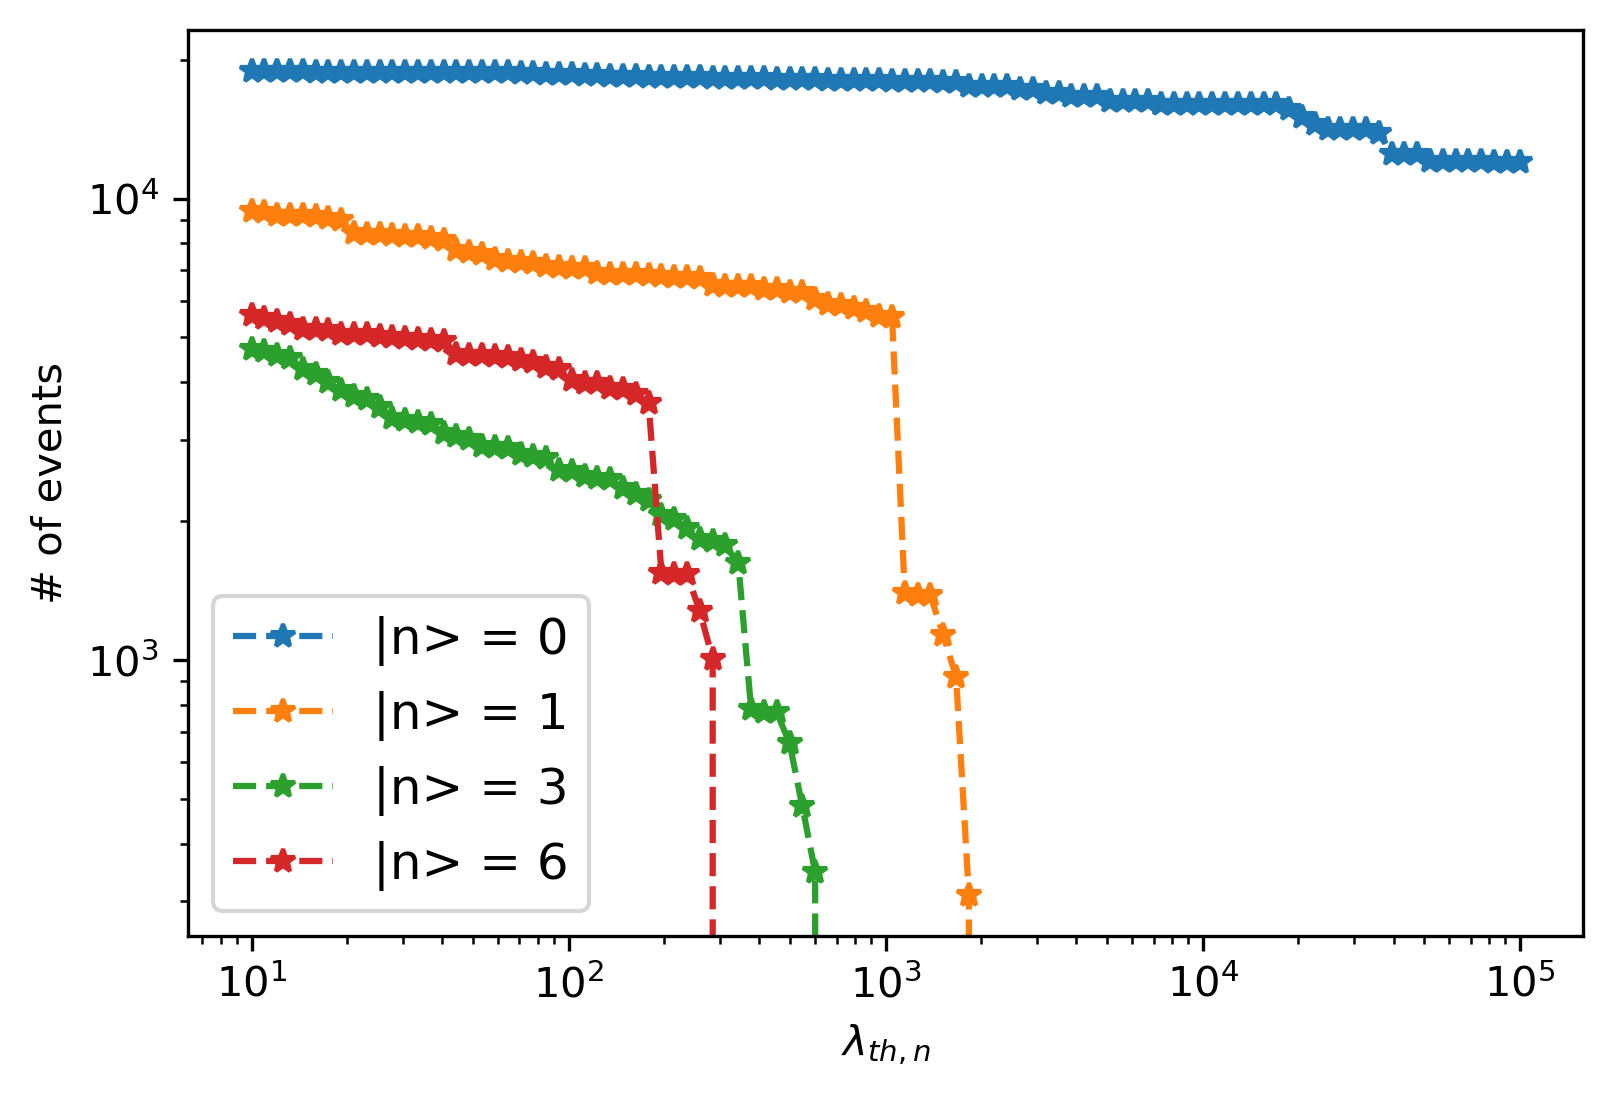

In [70]:
dm = pd.DataFrame(p_m_counts)
dn = pd.DataFrame(p_n_counts)

th_m = np.logspace(1, 5, 100)
th_n = np.logspace(1, 5, 100)

count_m = {}
count_n = {}
plt.figure(dpi=300)
cav_states = [0, 1, 3, 6]

for ii in range(len(dm)):
    ct_m = []
    for th in th_m:
        ct_m.append(dm.iloc[ii][dm.iloc[ii]>th].count())
    plt.loglog(th_m, ct_m, '*--', label='|n> = %i'%cav_states[ii])
    count_m['n%i'%ii] = ct_m
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda_{th, n}$')
plt.ylabel('# of events')
plt.show()

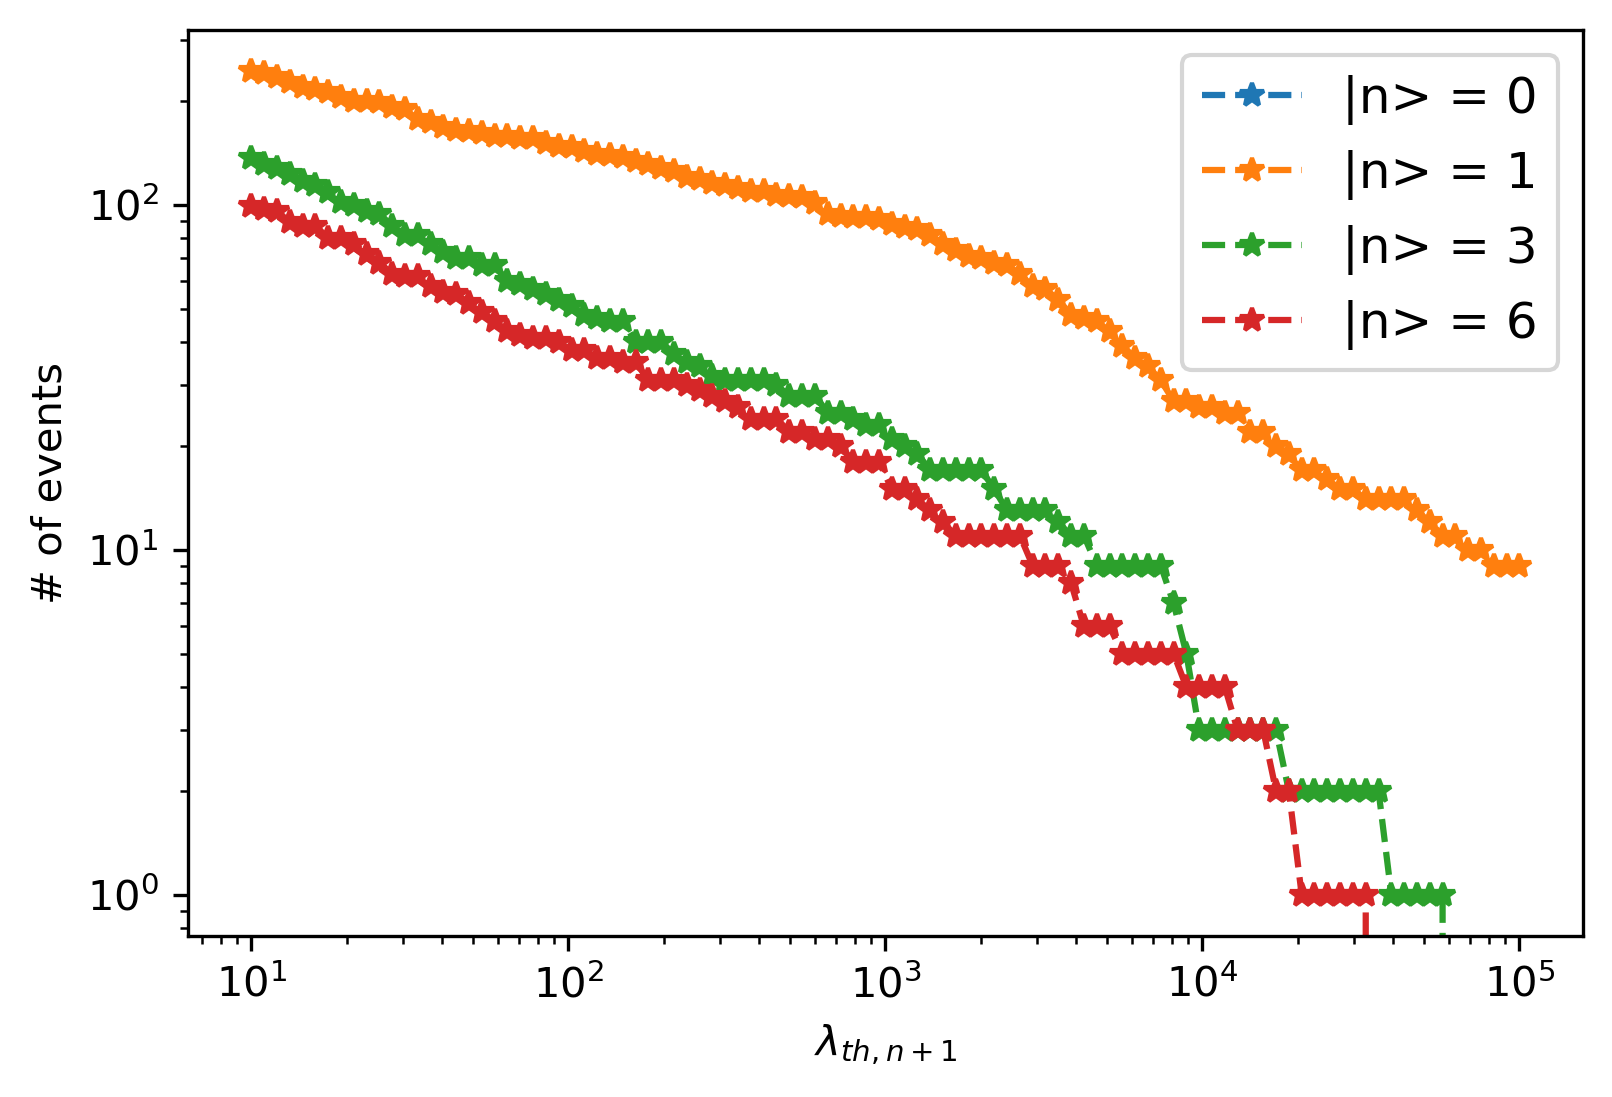

In [72]:
dm = pd.DataFrame(p_m_counts)
dn = pd.DataFrame(p_n_counts)

th_m = np.logspace(1, 5, 100)
th_n = np.logspace(1, 5, 100)

th1 = [1e4, 1e3, 2e2, 1e2]

count_m = {}
count_n = {}
frac_n = {}
plt.figure(dpi=300)
for ii in range(len(dm)):
    ct_n = []
    for th in th_n:
        ct_n.append(dn.iloc[ii][(dm.iloc[ii]>th1[ii]) & (dn.iloc[ii]>th)].count())
    plt.loglog(th_m, ct_n, '*--', label='|n> = %i'%cav_states[ii])
    count_n['n%i'%ii] = ct_n
    ct_m = dm.iloc[ii][dm.iloc[ii]>th1[ii]].count()
    frac_n['n%i'%ii] = ct_n/ct_m
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda_{th, n+1}$')
plt.ylabel('# of events')
plt.show()

In [ ]:
plt.figure(dpi=300)

for ii in range(len(dm)):
    plt.loglog(th_n, frac_n['n%i'%ii], '*--', label='|n> = %i'%ii)
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda_{th, n+1}$')
plt.ylabel(r'$\frac{P(n+1)}{P(n)}$')
# plt.ylim(1e-2, 1)
plt.show()

In [36]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 0

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth[:1]:
    
    readout_params['nth'] = nth
    camp = 0.1
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n0_camp_0.1_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.1, length = 10 ns


In [38]:
df = pd.DataFrame({'p_m': p_m_counts[0], 'p_n': p_n_counts[0]})

print(np.shape(df))
th1 = 1e2
th2 = 1e4

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_n = df['p_n'][df['p_n']>th2].count()
print(count_n)

(20000, 2)
18606
62


In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.00088,0.003671,0.000569,0.00088,0.00088,0.00088,0.00088,0.000569,0.00088,0.000935,...,77783.827452,0.00088,0.00088,0.00088,0.00088,0.00063,0.00088,0.000687,0.051843,0.00088


In [24]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[18878, 18340, 16713, 11989]]


In [11]:
th_m

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [53]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996]]


In [72]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[18201, 16516, 14248, 0], [18201, 16516, 14248, 0], [18201, 16516, 14248, 0], [18201, 16516, 14248, 0], [18201, 16516, 14248, 0]]


In [6]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[3853, 534, 419, 0], [3853, 534, 419, 0], [3853, 534, 419, 0], [3853, 534, 419, 0], [3853, 534, 419, 0]]


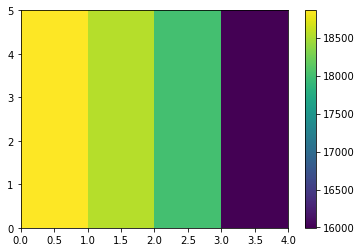

In [55]:
plt.pcolormesh( count_m, shading='auto')
plt.colorbar()
# plt.xscale('log')
plt.show()

In [27]:
th1 = 1e3
th2 = 1e4

df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_n = df['p_n'][df['p_n']>th2].count()
print(count_n)

count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()

print(count_p, count_p/count_m)

18008
13
1 5.553087516659262e-05


In [25]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 1

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth[:1]:
    
    readout_params['nth'] = nth
    camp = 0.001
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n1_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


In [26]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[11402, 9434, 7454, 4307]]


In [14]:
with File(filename, 'r') as a:
    bit = pd.DataFrame(a['bit'])

In [16]:
bit.iloc[1]

0     1
1     0
2     1
3     0
4     1
5     0
6     1
7     0
8     1
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
Name: 1, dtype: int64

In [61]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0]]


In [74]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0]]


In [28]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 3

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth[:1]:
    
    readout_params['nth'] = nth
    camp = 0.001
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n3_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


In [31]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 5)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[8388, 6025, 3805, 2090, 812]]


In [32]:
th_m

array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [76]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[4723, 2574, 0, 0], [4723, 2574, 0, 0], [4723, 2574, 0, 0], [4723, 2574, 0, 0], [4723, 2574, 0, 0]]


In [64]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 6

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth:
    
    readout_params['nth'] = nth
    camp = 0.001
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n6_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n6_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n6_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n6_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
['00000_stim_em_n6_camp_0.001_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


In [65]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[5593, 4053, 0, 0], [5593, 4053, 0, 0], [5593, 4053, 0, 0], [5593, 4053, 0, 0], [5593, 4053, 0, 0]]


# Stim Em with repeated pi pulses at |n>=0

## Camp = 0.0to 0.9

In [73]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 0

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n0_camp_0.001_len_10.h5']
n0//00000_stim_em_n0_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n0//injected_photon//n0_camp_0.001.h5
(20000, 2)
18580
11
['00000_stim_em_n0_camp_0.002_len_10.h5']
n0//00000_stim_em_n0_camp_0.002_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.002, length = 10 ns
[array(0.00144684)]
n0//injected_photon//n0_camp_0.002.h5
(20000, 2)
18568
16
['00000_stim_em_n0_camp_0.003_len_10.h5']
n0//00000_stim_em_n0_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n0//injected_photon//n0_camp_0.003.h5
(20000, 2)
18603
14
['00000_stim_em_n0_camp_0.004_len_10.h5']
n0//00000_stim_em_n0_camp_0.004_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.004, length = 10 ns
[array(0.00289368)]
n0//injected_photon//n0_camp_0.004.h5
(20000, 2)
18606
24
['00000_stim_em_n0_camp_0.005_len_10.h5']
n0//00000_stim_em_n0_camp_

In [13]:
th1 = 1e2
th2 = 1e4

df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_n = df['p_n'][df['p_n']>th2].count()
print(count_n)

count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()

print(count_p, count_p/count_m)

0
0
0 nan


<ipython-input-13-cb669fbd7c47>:13: RuntimeWarning: invalid value encountered in long_scalars
  print(count_p, count_p/count_m)


In [24]:
filename = 'C:\\_Lib\\python\\slab\\experiments\\qm_opx_mm\\data\\stim_em_oct_rp\\20220122\\n6\\00000_stim_em_n6_camp_0.01_len_10.h5'

In [25]:
with File(filename,'r') as a:
    bit = np.array(a["bit"])


## Photon counter fit

In [55]:
data_path =  "n0/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e5
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n0_camp_0.0.h5
Total number of events collected: 20000, 11990 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n0_camp_0.001.h5
Total number of events collected: 20000, 11989 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n0_camp_0.002.h5
Total number of events collected: 20000, 12067 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n0_camp_0.003.h5
Total number of events collected: 20000, 12040 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n0_camp_0.004.h5
Total number of events collected: 20000, 12145 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n0_camp_0.005.h5
Total number of events collected: 20000, 12039 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n0_camp_0.006.h5
Total number of events collected: 20000, 12044 events crossed $\lambda_{th, n}$ and 1 events crossed $\lambda_{th, n+1}$
n0_camp_0.007.h5
Total number of eve

In [49]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


ValueError: Residuals are not finite in the initial point.

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


ValueError: Residuals are not finite in the initial point.

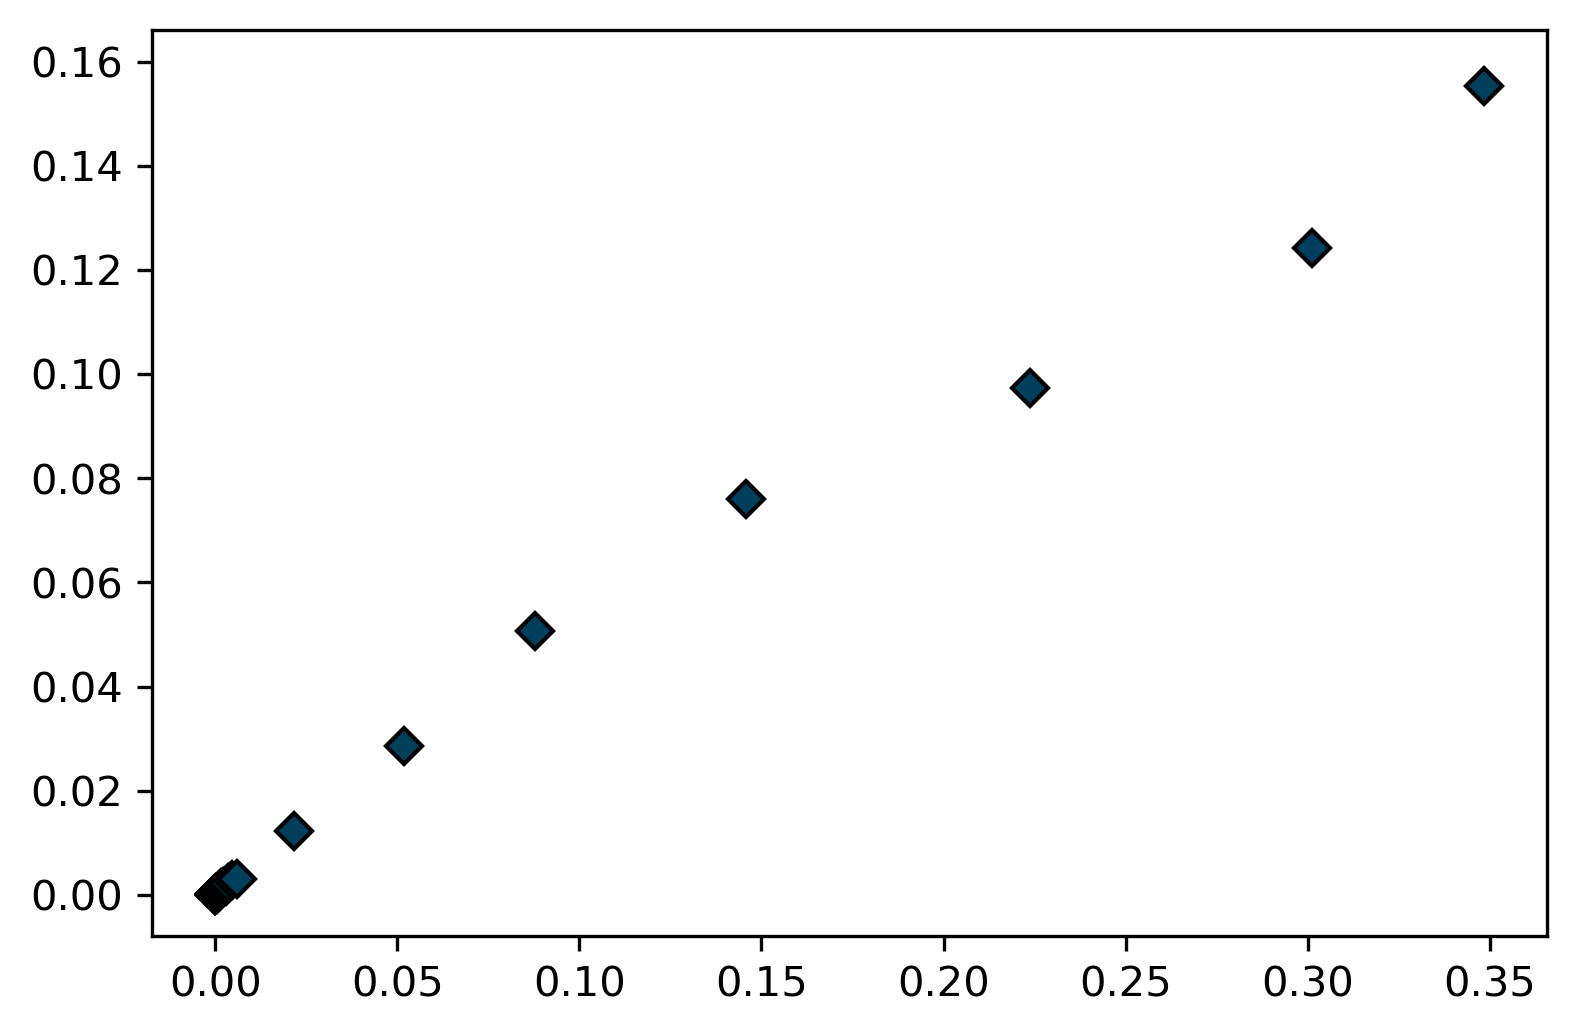

In [51]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 2
k = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:-k], y= np.array(y.iloc[-m], dtype=float)[:-k], yerr= np.array(yerr.iloc[-m], dtype=float)[:-k], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:-k], ydata=np.array(y.iloc[-m], dtype=float)[:-k], sigma=np.array(yerr.iloc[-m], dtype=float)[:-k], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-5, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 1

## Camp = 0.0, cav_len = 400ns

In [74]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 1

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n1_camp_0.001_len_10.h5']
n1//00000_stim_em_n1_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n1//injected_photon//n1_camp_0.001.h5
(20000, 2)
7075
724
['00000_stim_em_n1_camp_0.002_len_10.h5']
n1//00000_stim_em_n1_camp_0.002_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.002, length = 10 ns
[array(0.00144684)]
n1//injected_photon//n1_camp_0.002.h5
(20000, 2)
7100
673
['00000_stim_em_n1_camp_0.003_len_10.h5']
n1//00000_stim_em_n1_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n1//injected_photon//n1_camp_0.003.h5
(20000, 2)
7078
748
['00000_stim_em_n1_camp_0.004_len_10.h5']
n1//00000_stim_em_n1_camp_0.004_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.004, length = 10 ns
[array(0.00289368)]
n1//injected_photon//n1_camp_0.004.h5
(20000, 2)
7164
680
['00000_stim_em_n1_camp_0.005_len_10.h5']
n1//00000_stim_em_n1_camp_

## Photon counter line

In [56]:
data_path =  "n1/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e5
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n1_camp_0.0.h5
Total number of events collected: 20000, 4489 events crossed $\lambda_{th, n}$ and 17 events crossed $\lambda_{th, n+1}$
n1_camp_0.001.h5
Total number of events collected: 20000, 4307 events crossed $\lambda_{th, n}$ and 8 events crossed $\lambda_{th, n+1}$
n1_camp_0.002.h5
Total number of events collected: 20000, 4349 events crossed $\lambda_{th, n}$ and 7 events crossed $\lambda_{th, n+1}$
n1_camp_0.003.h5
Total number of events collected: 20000, 4384 events crossed $\lambda_{th, n}$ and 13 events crossed $\lambda_{th, n+1}$
n1_camp_0.004.h5
Total number of events collected: 20000, 4337 events crossed $\lambda_{th, n}$ and 8 events crossed $\lambda_{th, n+1}$
n1_camp_0.005.h5
Total number of events collected: 20000, 4416 events crossed $\lambda_{th, n}$ and 13 events crossed $\lambda_{th, n+1}$
n1_camp_0.006.h5
Total number of events collected: 20000, 4488 events crossed $\lambda_{th, n}$ and 10 events crossed $\lambda_{th, n+1}$
n1_camp_0.007.h5
Total number of events

In [56]:
55/7075, 1/18000

(0.0077738515901060075, 5.555555555555556e-05)

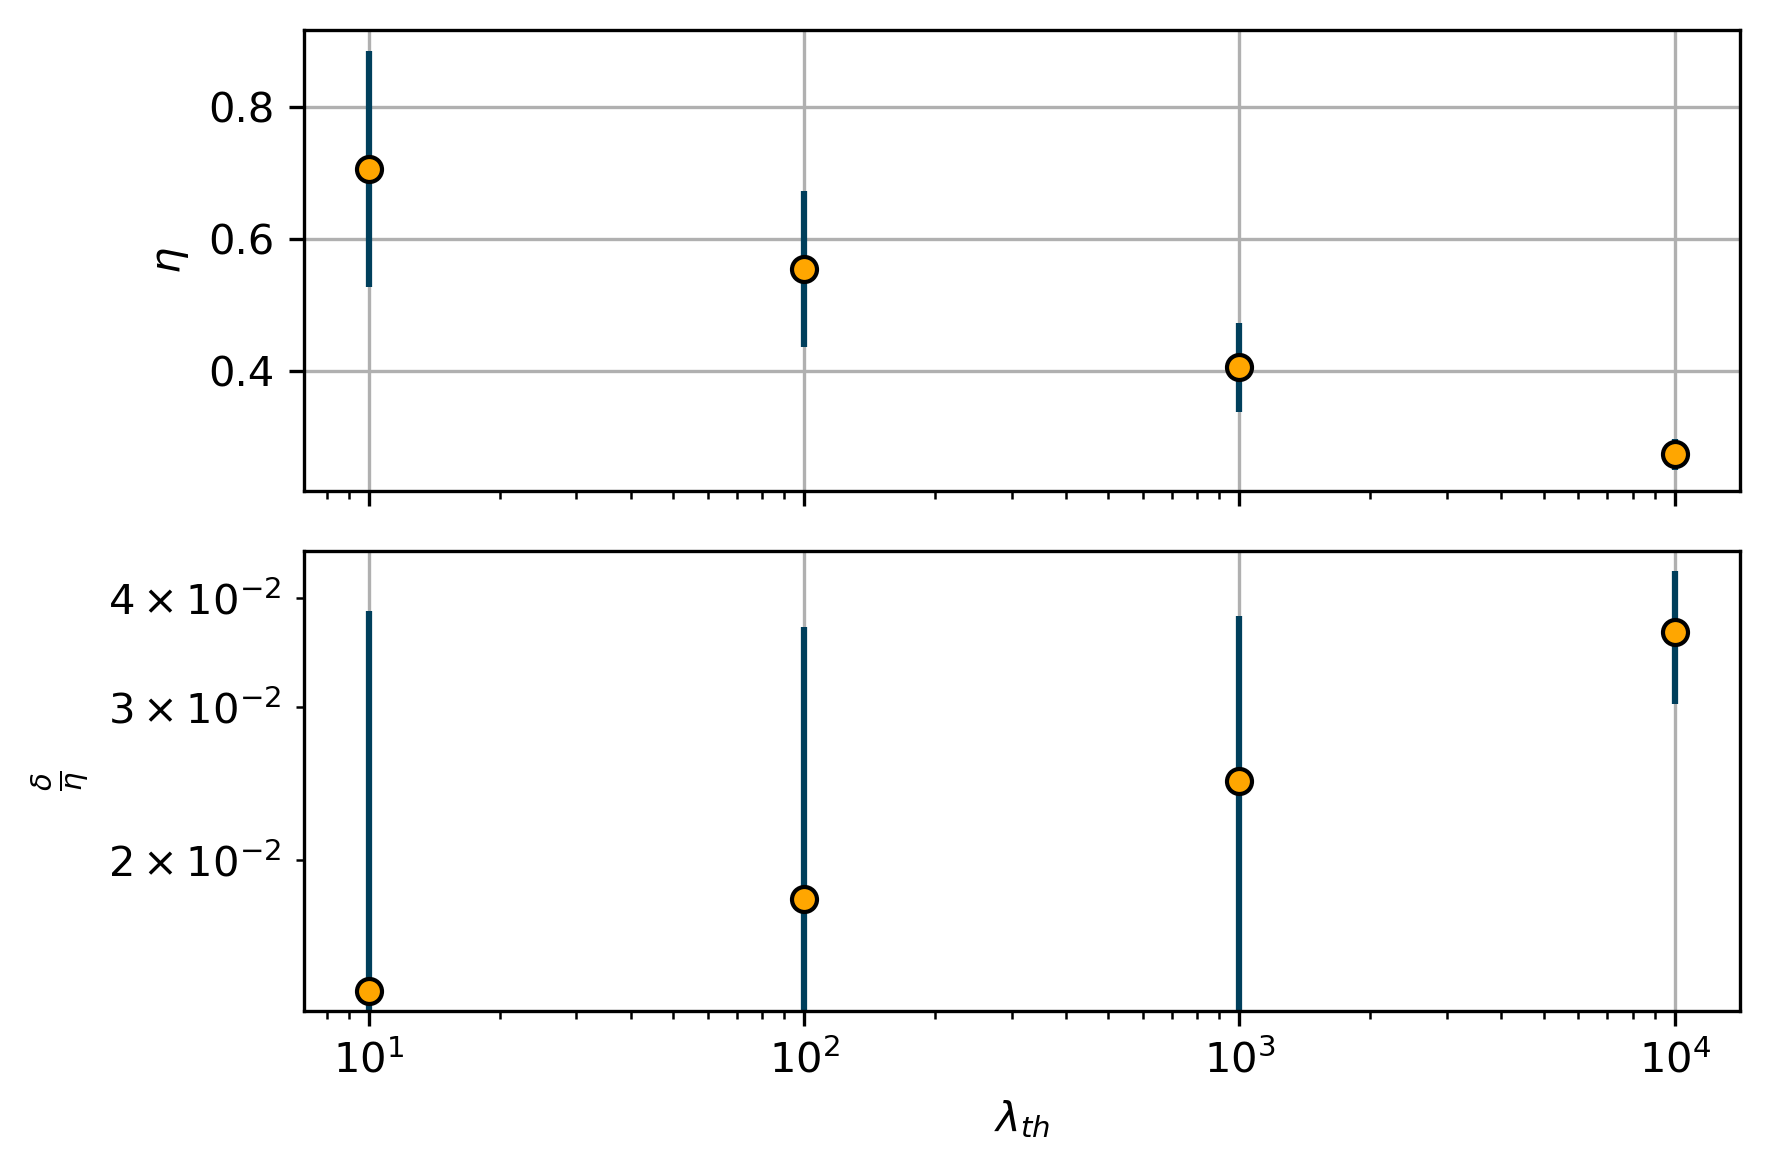

In [53]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.08209


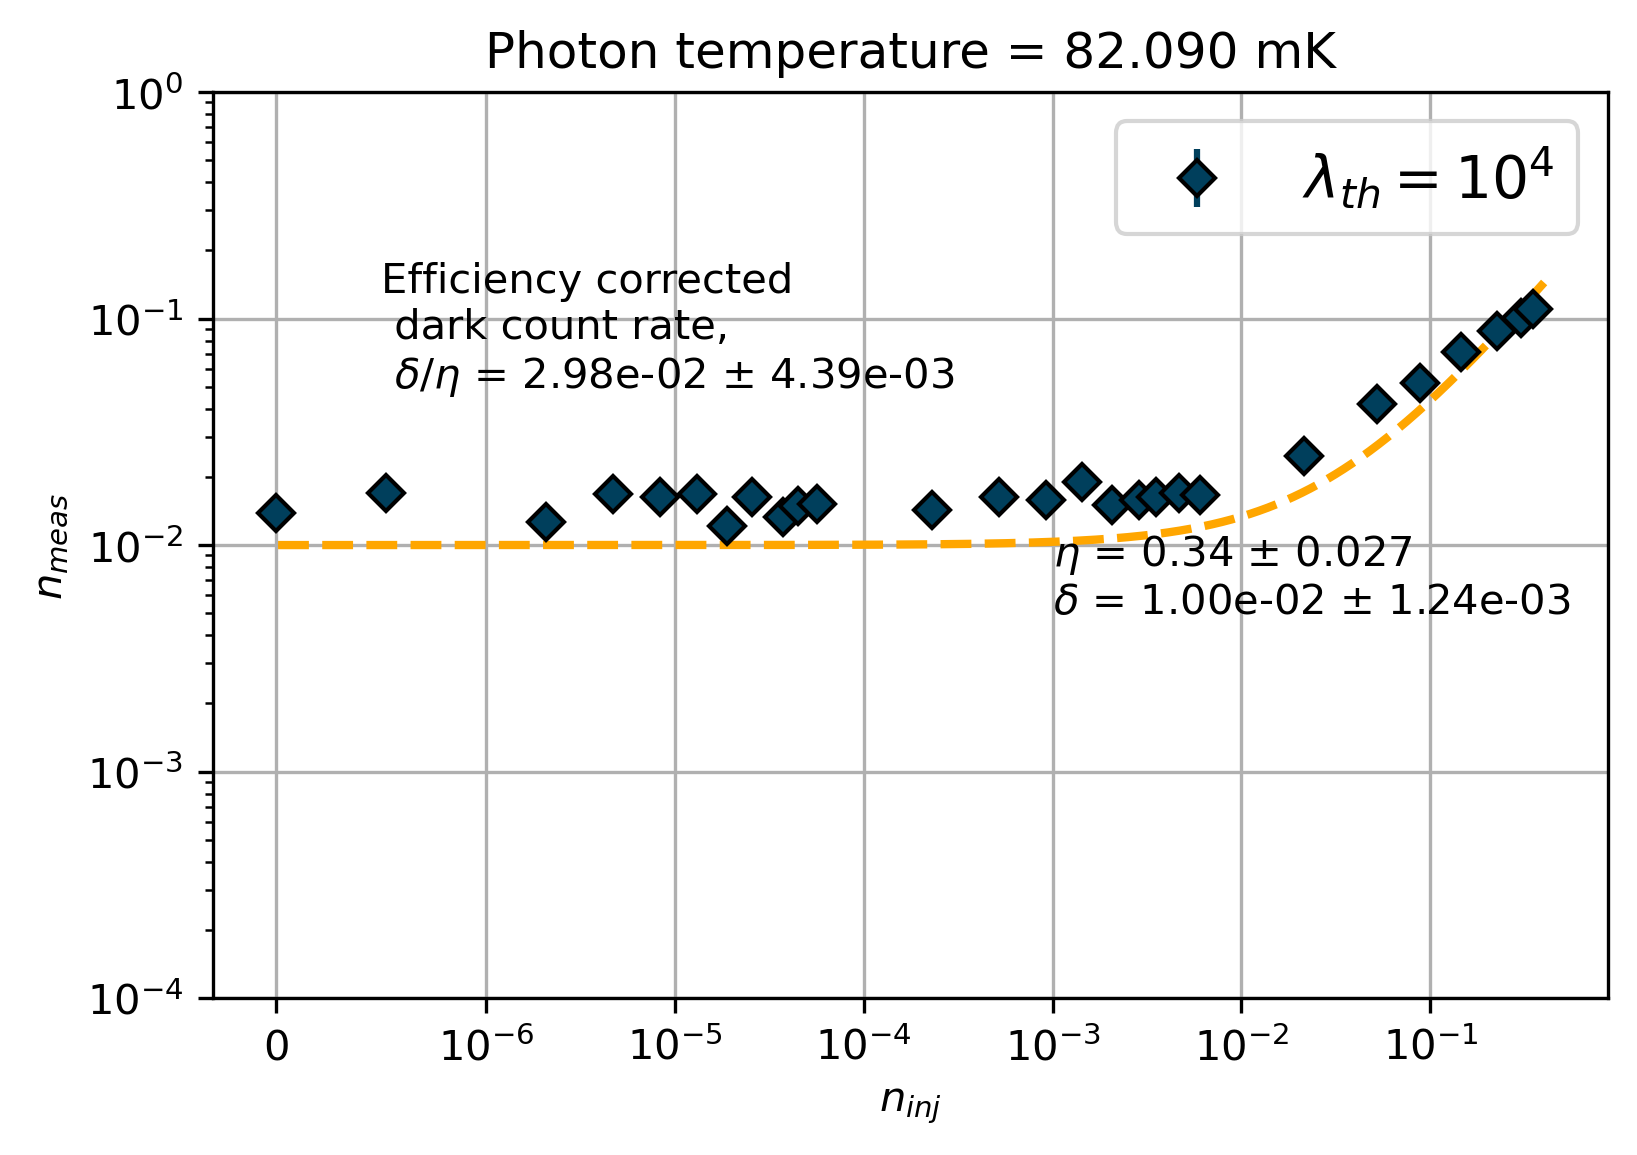

In [54]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
k = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:-k], y= np.array(y.iloc[-m], dtype=float)[:-k], yerr= np.array(yerr.iloc[-m], dtype=float)[:-k], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:-k], ydata=np.array(y.iloc[-m], dtype=float)[:-k], sigma=np.array(yerr.iloc[-m], dtype=float)[:-k], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [64]:
5e-2*(1-np.exp(-7/(2*1000))), 

0.00017469410697925627

# Stim Em with repeated pi pulses at |n> = 2

## Camp = 0.0, cav_len = 400 ns

In [57]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 2

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n2_camp_0.01_len_10.h5', '00001_stim_em_n2_camp_0.01_len_10.h5']
..//data//stim_em//n2//00000_stim_em_n2_camp_0.01_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.01, length = 10 ns
[0 1 2 3] [2007 1220 5323 1450]
..//data//stim_em//n2//00001_stim_em_n2_camp_0.01_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.01, length = 10 ns
[0 1 2 3] [4702 2496 9780 3022]
[0.001716571275186967, 0.001716571275186967]
..//data//stim_em//n2//injected_photon//n2_camp_0.01.h5
(15103, 2)
3016
64
['00000_stim_em_n2_camp_0.02_len_10.h5', '00001_stim_em_n2_camp_0.02_len_10.h5']
..//data//stim_em//n2//00000_stim_em_n2_camp_0.02_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.02, length = 10 ns
[0 1 2 3] [2032 1233 5287 1448]
..//data//stim_em//n2//00001_stim_em_n2_camp_0.02_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.02, length = 10 ns
[0 1 2 3] [4598 2495 9789 3118]
[0.0035299340835694567, 0.0035299340835694567]
..//data//stim_em//n2//

## Photon counter fit

In [6]:
data_path =  "n2/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e5
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/stim_em_2//n2/injected_photon/'

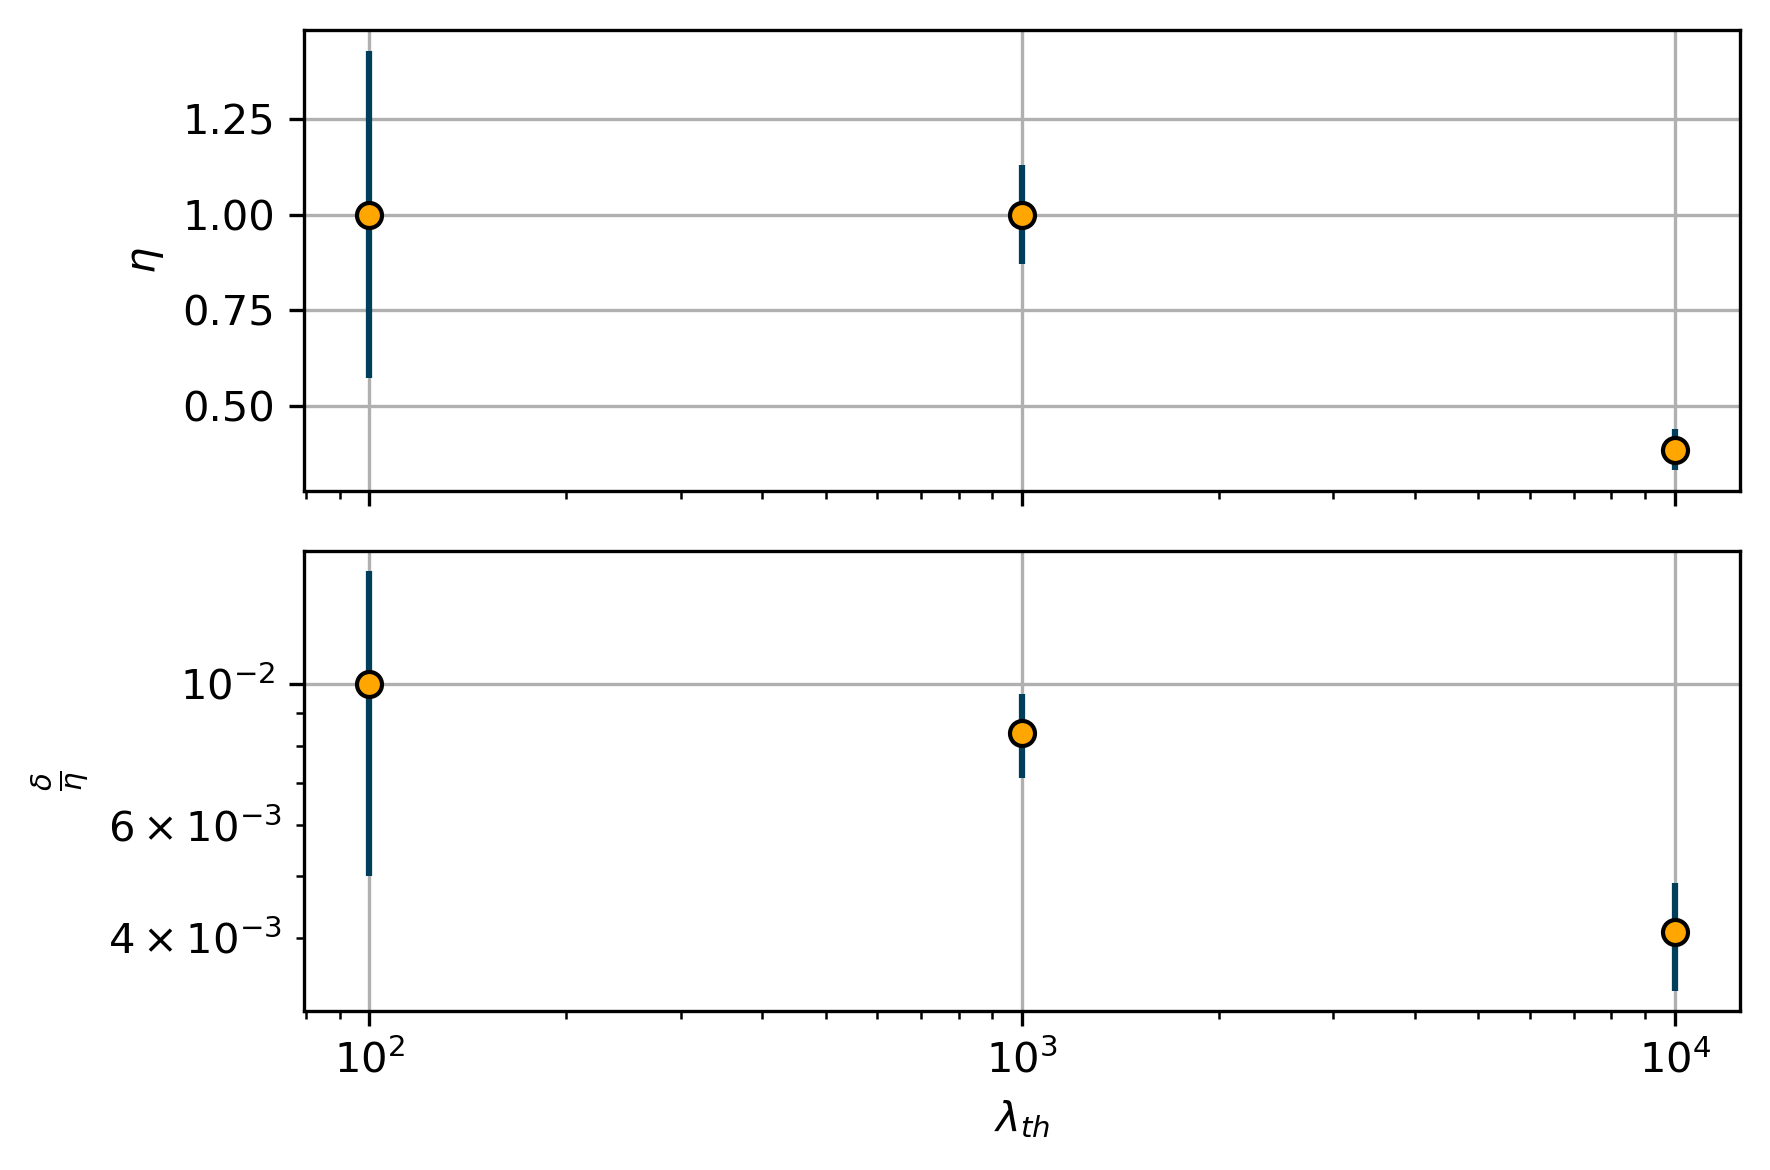

In [74]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)*3) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.05246


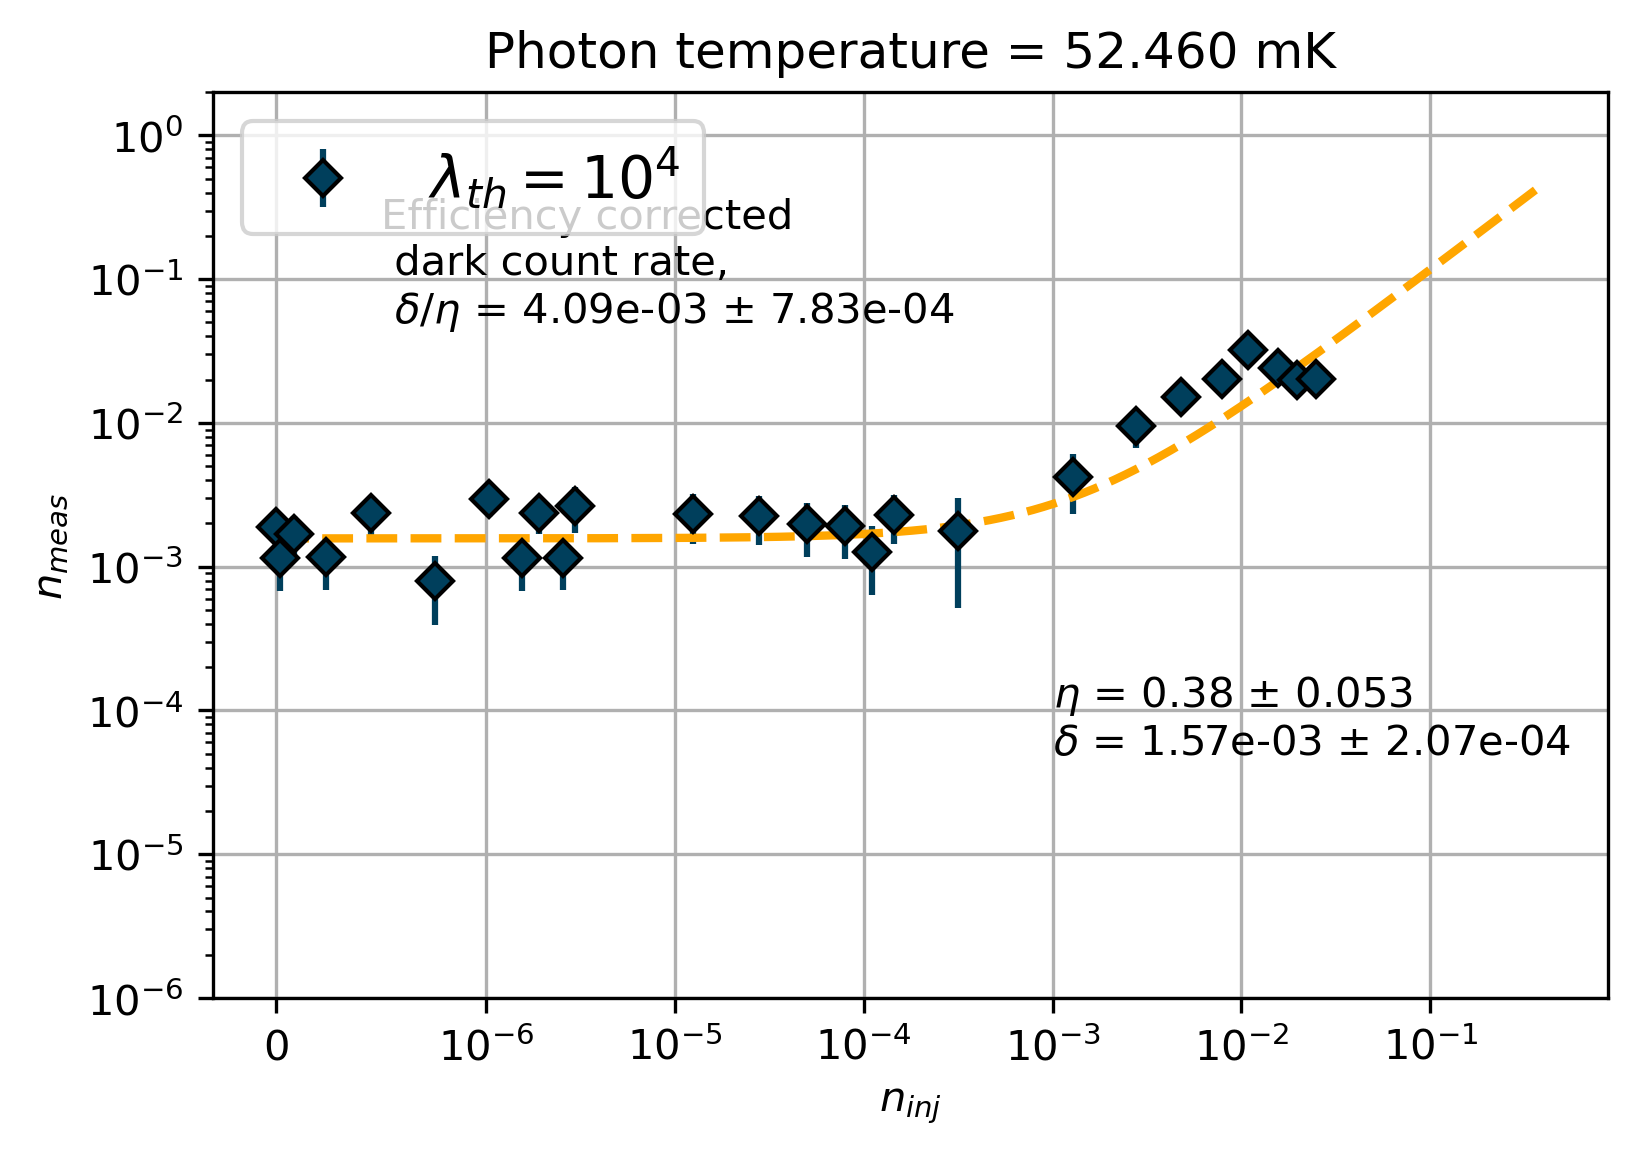

In [75]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 3

## Camp = 0.05, cav_len = 400 ns

In [75]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
# camp.append(0.0)

fock_state = 3

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n3_camp_0.001_len_10.h5']
n3//00000_stim_em_n3_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n3//injected_photon//n3_camp_0.001.h5
(20000, 2)
2574
62
['00000_stim_em_n3_camp_0.002_len_10.h5']
n3//00000_stim_em_n3_camp_0.002_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.002, length = 10 ns
[array(0.00144684)]
n3//injected_photon//n3_camp_0.002.h5
(20000, 2)
2573
72
['00000_stim_em_n3_camp_0.003_len_10.h5']
n3//00000_stim_em_n3_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n3//injected_photon//n3_camp_0.003.h5
(20000, 2)
2546
61
['00000_stim_em_n3_camp_0.004_len_10.h5']
n3//00000_stim_em_n3_camp_0.004_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.004, length = 10 ns
[array(0.00289368)]
n3//injected_photon//n3_camp_0.004.h5
(20000, 2)
2435
60
['00000_stim_em_n3_camp_0.005_len_10.h5']
n3//00000_stim_em_n3_camp_0.00

## Photon counter fit

In [62]:
data_path =  "n3/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e2
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n3_camp_0.0.h5
Total number of events collected: 20000, 2546 events crossed $\lambda_{th, n}$ and 9 events crossed $\lambda_{th, n+1}$
n3_camp_0.001.h5
Total number of events collected: 20000, 6025 events crossed $\lambda_{th, n}$ and 17 events crossed $\lambda_{th, n+1}$
n3_camp_0.002.h5
Total number of events collected: 20000, 6097 events crossed $\lambda_{th, n}$ and 19 events crossed $\lambda_{th, n+1}$
n3_camp_0.003.h5
Total number of events collected: 20000, 6106 events crossed $\lambda_{th, n}$ and 14 events crossed $\lambda_{th, n+1}$
n3_camp_0.004.h5
Total number of events collected: 20000, 5919 events crossed $\lambda_{th, n}$ and 12 events crossed $\lambda_{th, n+1}$
n3_camp_0.005.h5
Total number of events collected: 20000, 6044 events crossed $\lambda_{th, n}$ and 10 events crossed $\lambda_{th, n+1}$
n3_camp_0.006.h5
Total number of events collected: 20000, 6092 events crossed $\lambda_{th, n}$ and 15 events crossed $\lambda_{th, n+1}$
n3_camp_0.007.h5
Total number of even

In [53]:
3/2574

0.0011655011655011655

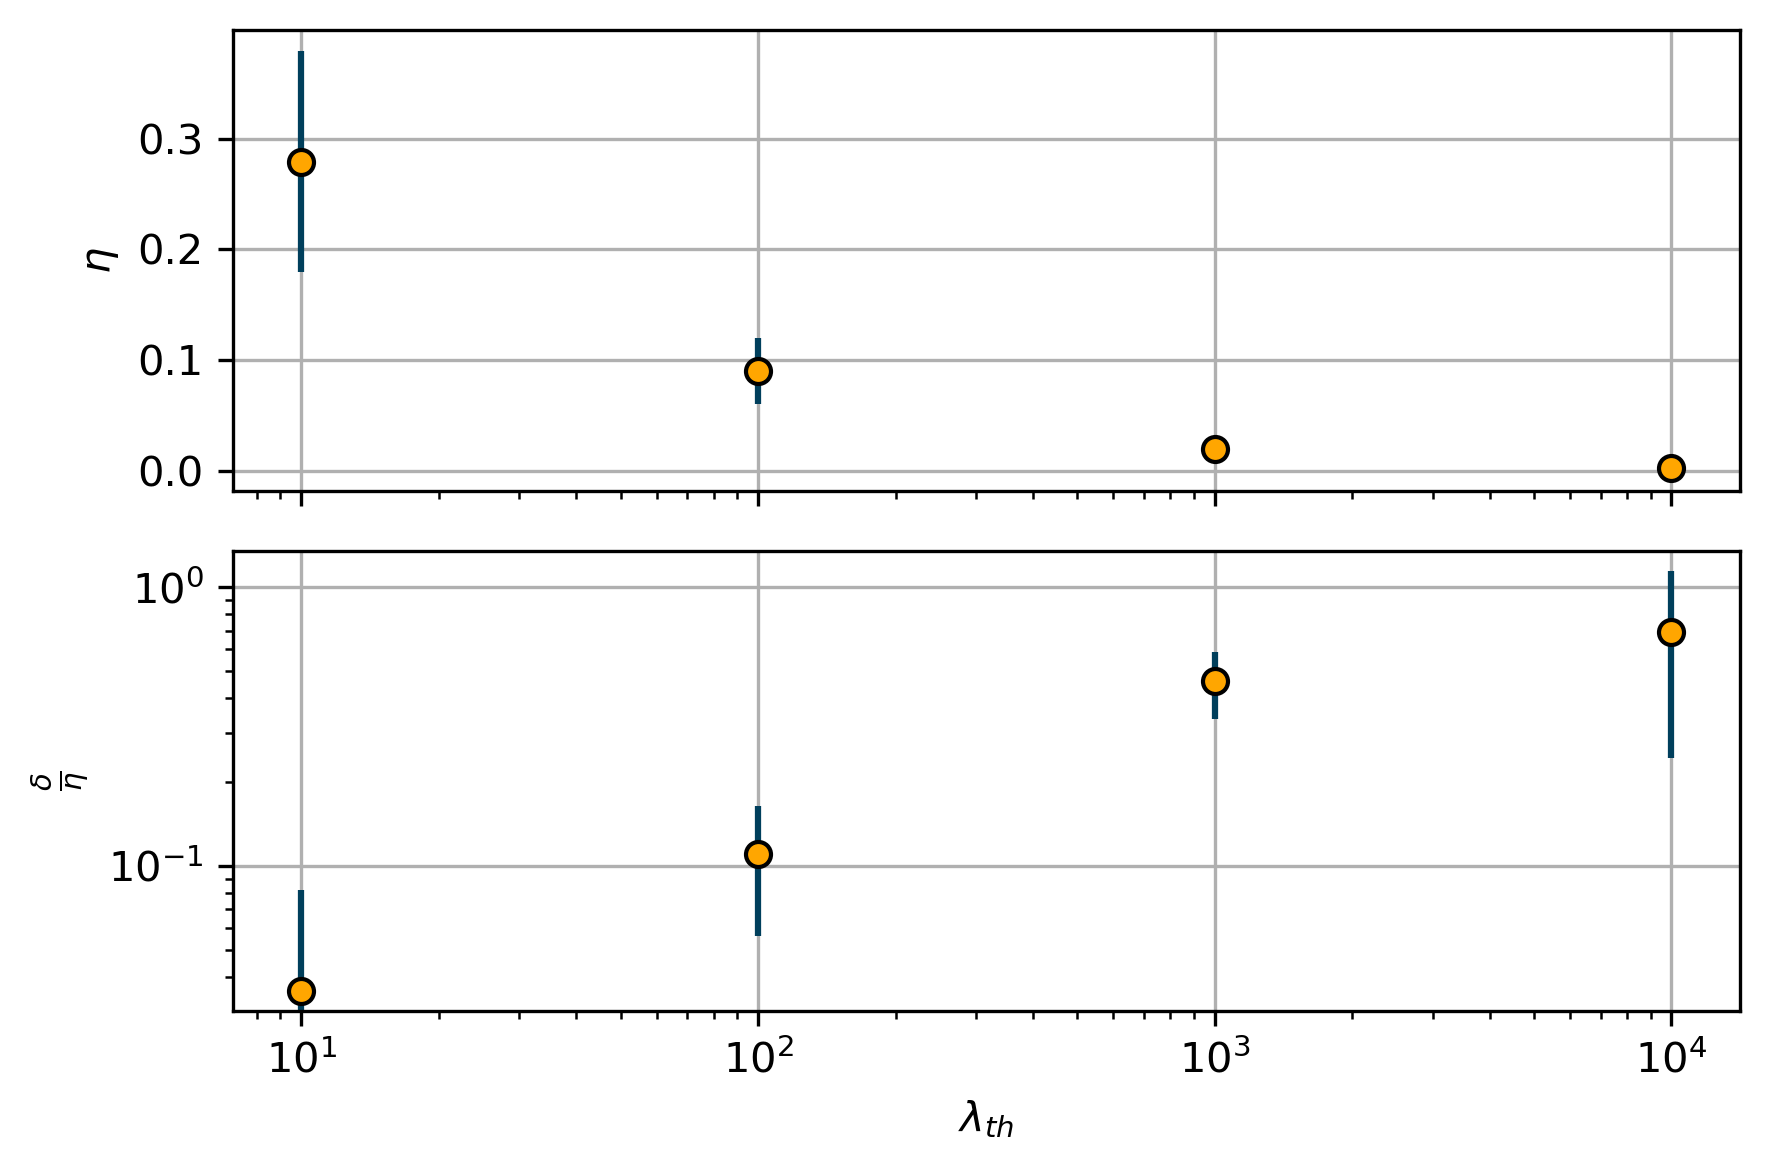

In [44]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.06795


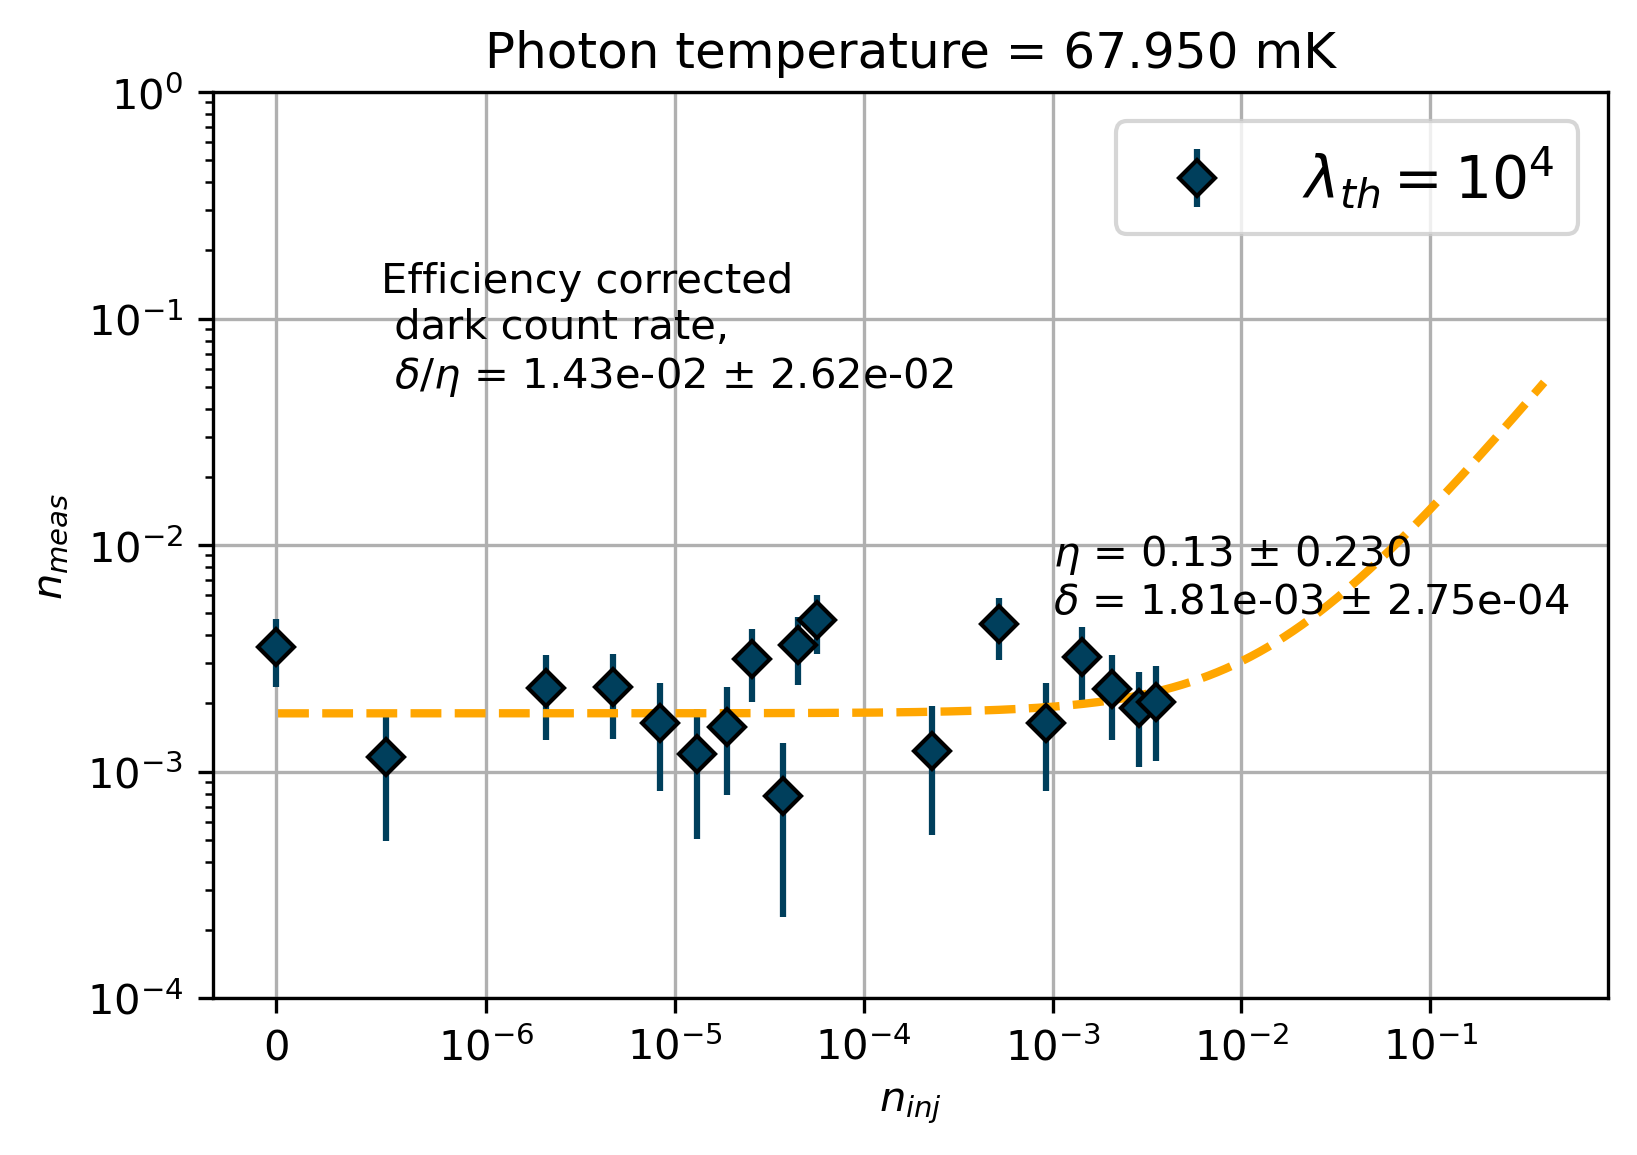

In [45]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
k = 10
plt.figure(dpi=300)
plt.errorbar(n_exp[:-k], y= np.array(y.iloc[-m], dtype=float)[:-k], yerr= np.array(yerr.iloc[-m], dtype=float)[:-k], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:-k], ydata=np.array(y.iloc[-m], dtype=float)[:-k], sigma=np.array(yerr.iloc[-m], dtype=float)[:-k], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [48]:
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = hbar*w/(k*np.log(1/3.28e-4))
print(T)

0.03595919112878462


# Stim Em with repeated pi pulses at |n> = 6

In [76]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 6

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n6_camp_0.001_len_10.h5']
n6//00000_stim_em_n6_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n6//injected_photon//n6_camp_0.001.h5
(20000, 2)
4053
109
['00000_stim_em_n6_camp_0.002_len_10.h5']
n6//00000_stim_em_n6_camp_0.002_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.002, length = 10 ns
[array(0.00144684)]
n6//injected_photon//n6_camp_0.002.h5
(20000, 2)
3981
98
['00000_stim_em_n6_camp_0.003_len_10.h5']
n6//00000_stim_em_n6_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n6//injected_photon//n6_camp_0.003.h5
(20000, 2)
4064
116
['00000_stim_em_n6_camp_0.004_len_10.h5']
n6//00000_stim_em_n6_camp_0.004_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.004, length = 10 ns
[array(0.00289368)]
n6//injected_photon//n6_camp_0.004.h5
(20000, 2)
4150
111
['00000_stim_em_n6_camp_0.005_len_10.h5']
n6//00000_stim_em_n6_camp_0

In [77]:
data_path =  "n6/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e2
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n6_camp_0.0.h5


ZeroDivisionError: division by zero

In [45]:
th_n

array([   10.,   100.,  1000., 10000.])

0.04462


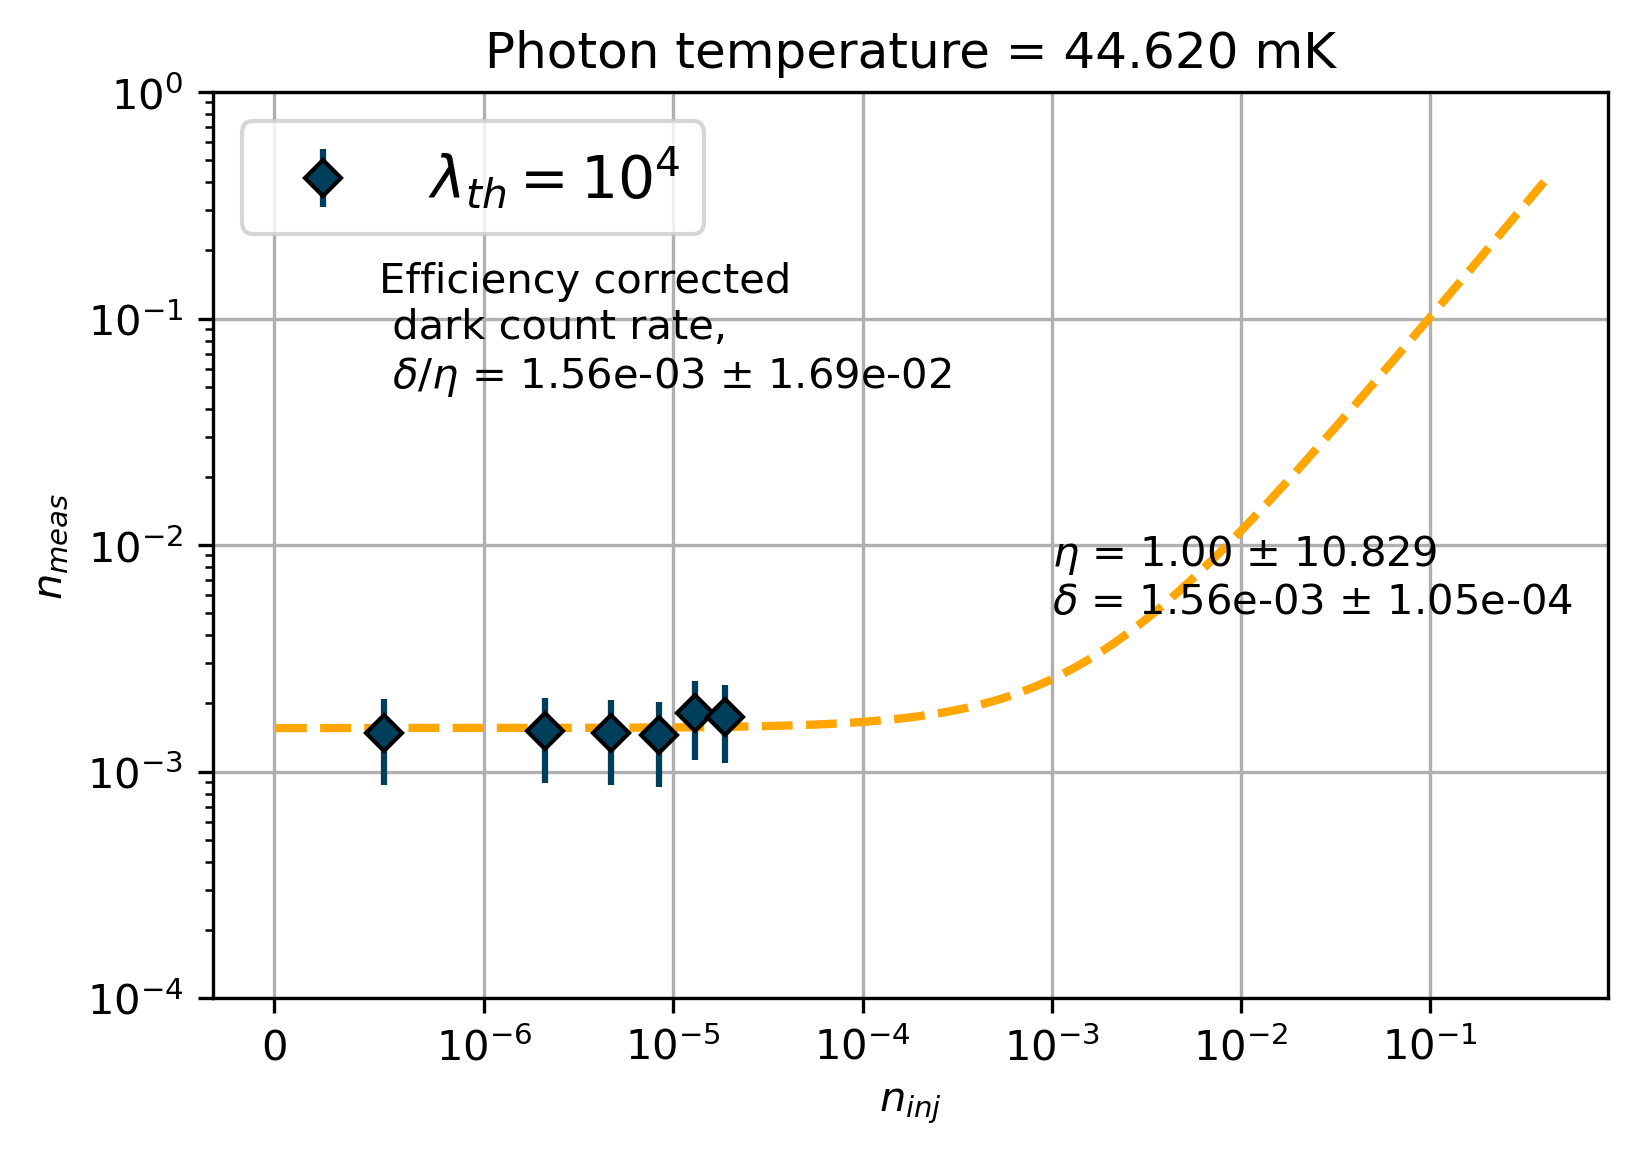

In [41]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:], y= np.array(y.iloc[-m], dtype=float)[:], yerr= np.array(yerr.iloc[-m], dtype=float)[:], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:], ydata=np.array(y.iloc[-m], dtype=float)[:], sigma=np.array(yerr.iloc[-m], dtype=float)[:], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [51]:
6/4053

0.0014803849000740192